In [1]:
# 02_data_exploration.ipynb

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('default')
sns.set_theme()

In [2]:
def load_preprocessed_data():
    """Load the preprocessed data and return the dataframe"""
    data_path = Path('../data/processed/preprocessed_data.csv')
    if not data_path.exists():
        raise FileNotFoundError("Preprocessed data not found. Please run 01_data_preprocessing first.")
    
    df = pd.read_csv(data_path)
    print(f"Loaded data with shape: {df.shape}")
    return df

# Load data
print("Loading preprocessed data...")
df = load_preprocessed_data()

Loading preprocessed data...
Loaded data with shape: (10094, 2359)



Depression Score Analysis:

Basic Statistics:
count    1.009400e+04
mean     8.447110e-18
std      1.000050e+00
min     -6.705033e-01
25%     -6.705033e-01
50%     -2.737823e-01
75%      1.229387e-01
max      7.660638e+00
Name: depression_score, dtype: float64


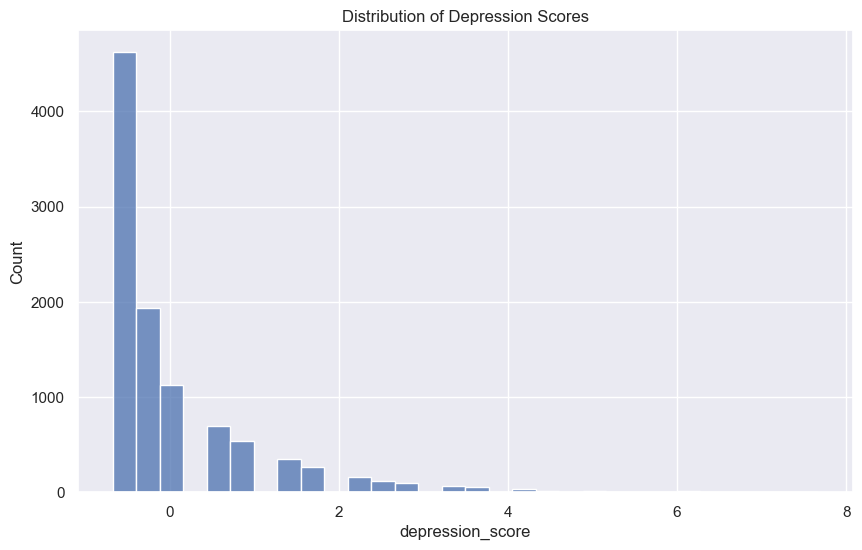


Percentiles:
25th percentile: -0.67
50th percentile: -0.27
75th percentile: 0.12
90th percentile: 1.31
95th percentile: 2.11
99th percentile: 3.69


In [3]:
def analyze_depression_scores(df):
    """Analyze the distribution and characteristics of depression scores"""
    print("\nDepression Score Analysis:")
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(df['depression_score'].describe())
    
    # Distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='depression_score', bins=30)
    plt.title('Distribution of Depression Scores')
    plt.show()
    
    # Calculate percentiles
    percentiles = [25, 50, 75, 90, 95, 99]
    print("\nPercentiles:")
    for p in percentiles:
        value = df['depression_score'].quantile(p/100)
        print(f"{p}th percentile: {value:.2f}")

# Analyze depression scores
analyze_depression_scores(df)

In [4]:
def identify_variable_types(df, unique_threshold=10, sample_ratio_threshold=0.1):
    """
    Identify continuous, categorical, and binary variables
    """
    continuous_vars = []
    categorical_vars = []
    binary_vars = []
    
    for col in df.columns:
        if col in ['src_subject_id', 'depression_score']:
            continue
            
        n_unique = df[col].nunique()
        n_samples = len(df)
        unique_ratio = n_unique / n_samples
        is_numeric = pd.api.types.is_numeric_dtype(df[col])
        
        # Binary variables
        if n_unique == 2:
            binary_vars.append(col)
            continue
            
        # Non-numeric variables are categorical
        if not is_numeric:
            categorical_vars.append(col)
            continue
            
        # Numeric variables need further investigation
        if is_numeric:
            is_integer = df[col].dtype in ['int32', 'int64']
            if (is_integer and n_unique <= unique_threshold) or \
               (n_unique <= unique_threshold and unique_ratio <= sample_ratio_threshold):
                value_counts = df[col].value_counts(normalize=True)
                if value_counts.max() < 0.5:  # No single value dominates
                    categorical_vars.append(col)
                else:
                    continuous_vars.append(col)
            else:
                continuous_vars.append(col)
    
    print("\nVariable type identification results:")
    print(f"Continuous variables: {len(continuous_vars)}")
    print(f"Categorical variables: {len(categorical_vars)}")
    print(f"Binary variables: {len(binary_vars)}")
    
    return {
        'continuous': continuous_vars,
        'categorical': categorical_vars,
        'binary': binary_vars
    }
    

In [5]:
def calculate_correlations(df, dep_col='depression_score'):
    """Calculate appropriate correlations based on variable type"""
    var_types = identify_variable_types(df)
    correlations = {}
    
    # Calculate Pearson correlations for continuous variables
    print("\nCalculating continuous correlations...")
    for col in var_types['continuous']:
        try:
            corr_value = df[col].corr(df[dep_col])
            if not pd.isna(corr_value):
                correlations[col] = {
                    'correlation': corr_value,
                    'type': 'continuous',
                    'method': 'pearson'
                }
                print(f"Found continuous correlation for {col}: {corr_value:.3f}")
        except Exception as e:
            print(f"Error with continuous variable {col}: {str(e)}")
            continue
    
    # Calculate point-biserial correlations for binary variables
    print("\nCalculating binary correlations...")
    for col in var_types['binary']:
        try:
            corr_value = stats.pointbiserialr(df[col], df[dep_col])[0]
            if not pd.isna(corr_value):
                correlations[col] = {
                    'correlation': corr_value,
                    'type': 'binary',
                    'method': 'point-biserial'
                }
                print(f"Found binary correlation for {col}: {corr_value:.3f}")
        except Exception as e:
            print(f"Error with binary variable {col}: {str(e)}")
            continue
    
    # Calculate Cramer's V for categorical variables
    print("\nCalculating categorical correlations...")
    for col in var_types['categorical']:
        try:
            # Create depression score bins using cut instead of qcut
            dep_bins = pd.cut(df[dep_col], 
                            bins=[-float('inf'), 5, 10, 15, float('inf')],
                            labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
            
            # Create contingency table
            contingency = pd.crosstab(df[col], dep_bins)
            
            # Calculate chi-square statistic
            chi2 = stats.chi2_contingency(contingency)[0]
            
            # Calculate Cramer's V
            n = len(df)
            min_dim = min(len(df[col].unique()), len(dep_bins.unique())) - 1
            if min_dim > 0:
                cramer_v = np.sqrt(chi2 / (n * min_dim))
                if not pd.isna(cramer_v):
                    correlations[col] = {
                        'correlation': cramer_v,
                        'type': 'categorical',
                        'method': 'cramer_v'
                    }
                    print(f"Found categorical correlation for {col}: {cramer_v:.3f}")
        except Exception as e:
            print(f"Error with categorical variable {col}: {str(e)}")
            continue
    
    return correlations

In [24]:
def plot_continuous_correlations(df, top_vars, dep_col='depression_score'):
    """Create scatter plots for continuous variables"""
    n_cols = 5
    n_rows = (len(top_vars) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    fig.suptitle('Top Continuous Variables vs Depression Score', fontsize=16, y=0.95)
    
    if n_rows == 1:
        axes = [axes]
    
    for idx, (var, row) in enumerate(top_vars.iterrows()):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row_idx][col_idx]
        
        sns.regplot(data=df, x=var, y=dep_col, ax=ax, 
                   scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
        ax.set_title(f'{var}\nr = {row["correlation"]:.2f}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=6)
        
        if len(var) > 20:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Hide empty subplots
    for idx in range(len(top_vars), n_rows * n_cols):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        axes[row_idx][col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_categorical_correlations(df, top_vars, dep_col='depression_score'):
    """Create boxplots for categorical/binary variables"""
    n_cols = 5
    n_rows = (len(top_vars) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    fig.suptitle('Top Categorical/Binary Variables vs Depression Score', fontsize=16, y=0.95)
    
    if n_rows == 1:
        axes = [axes]
    
    for idx, (var, row) in enumerate(top_vars.iterrows()):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row_idx][col_idx]
        
        sns.boxplot(data=df, x=var, y=dep_col, ax=ax)
        ax.set_title(f'{var}\n{row["method"]} = {row["correlation"]:.2f}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=6)
        
        if len(var) > 20:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Hide empty subplots
    for idx in range(len(top_vars), n_rows * n_cols):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        axes[row_idx][col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [7]:
# Calculate correlations
correlations = calculate_correlations(df)
corr_df = pd.DataFrame.from_dict(correlations, orient='index')

# Print correlation counts by type
print("\nNumber of correlations by type:")
print(corr_df['type'].value_counts())

# Get top correlations by absolute value for each type
top_n = 20
top_continuous = corr_df[corr_df['type'] == 'continuous'].nlargest(top_n, 'correlation')
top_binary = corr_df[corr_df['type'] == 'binary'].nlargest(top_n, 'correlation')
top_categorical = corr_df[corr_df['type'] == 'categorical'].nlargest(top_n, 'correlation')

# Print summary of correlations found
print("\nSummary of correlations found:")
print(f"Continuous variables: {len(top_continuous)}")
print(f"Binary variables: {len(top_binary)}")
print(f"Categorical variables: {len(top_categorical)}")

# Print top correlations for each type
print("\nTop Continuous Variables:")
print(top_continuous[['correlation', 'method']].head())
print("\nTop Binary Variables:")
print(top_binary[['correlation', 'method']].head())
print("\nTop Categorical Variables:")
print(top_categorical[['correlation', 'method']].head())


Variable type identification results:
Continuous variables: 2156
Categorical variables: 144
Binary variables: 57

Calculating continuous correlations...
Found continuous correlation for ledsch_seda_c_hsecdnec_linked-external-data_led_l_seda_demo_c: -0.022
Found continuous correlation for ledsch_seda_c_hsflnfl_linked-external-data_led_l_seda_demo_c: -0.010
Found continuous correlation for ledsch_seda_c_perasn_linked-external-data_led_l_seda_demo_c: -0.019
Found continuous correlation for ledsch_seda_c_perblk_linked-external-data_led_l_seda_demo_c: -0.010
Found continuous correlation for ledsch_seda_c_perecd_linked-external-data_led_l_seda_demo_c: -0.015
Found continuous correlation for ledsch_seda_c_perhsp_linked-external-data_led_l_seda_demo_c: -0.014
Found continuous correlation for ledsch_seda_c_perind_linked-external-data_led_l_seda_demo_c: 0.026
Found continuous correlation for ledsch_seda_c_perrl_linked-external-data_led_l_seda_demo_c: -0.002
Found continuous correlation for leds

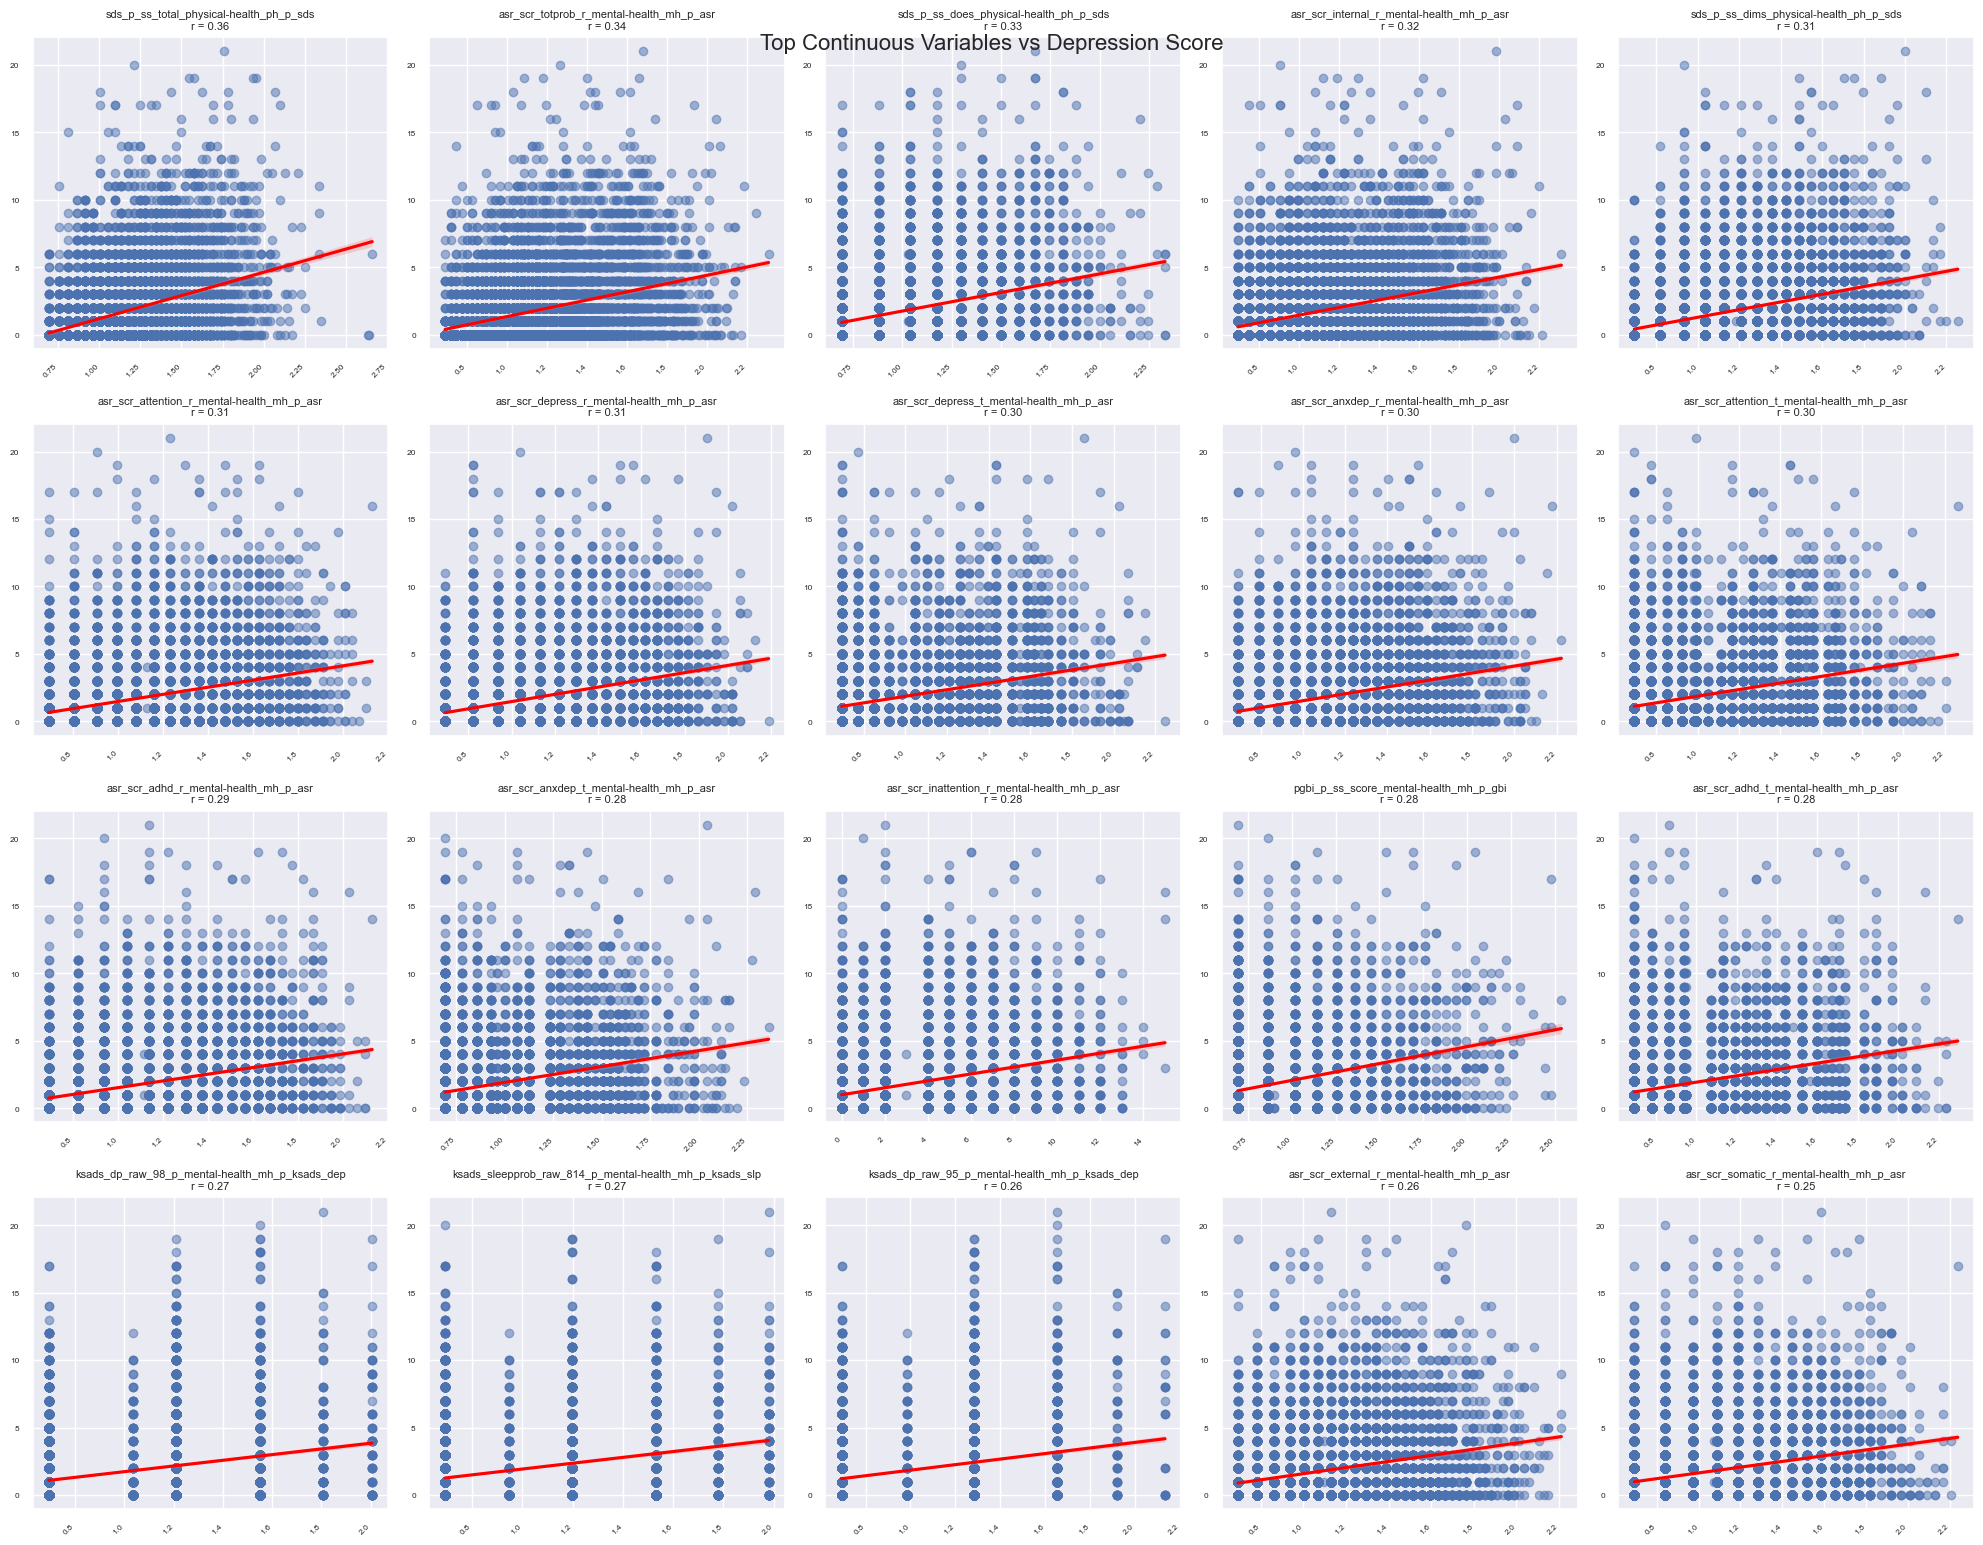

In [17]:
# Plot continuous correlations
if not top_continuous.empty:
    plot_continuous_correlations(df, top_continuous)


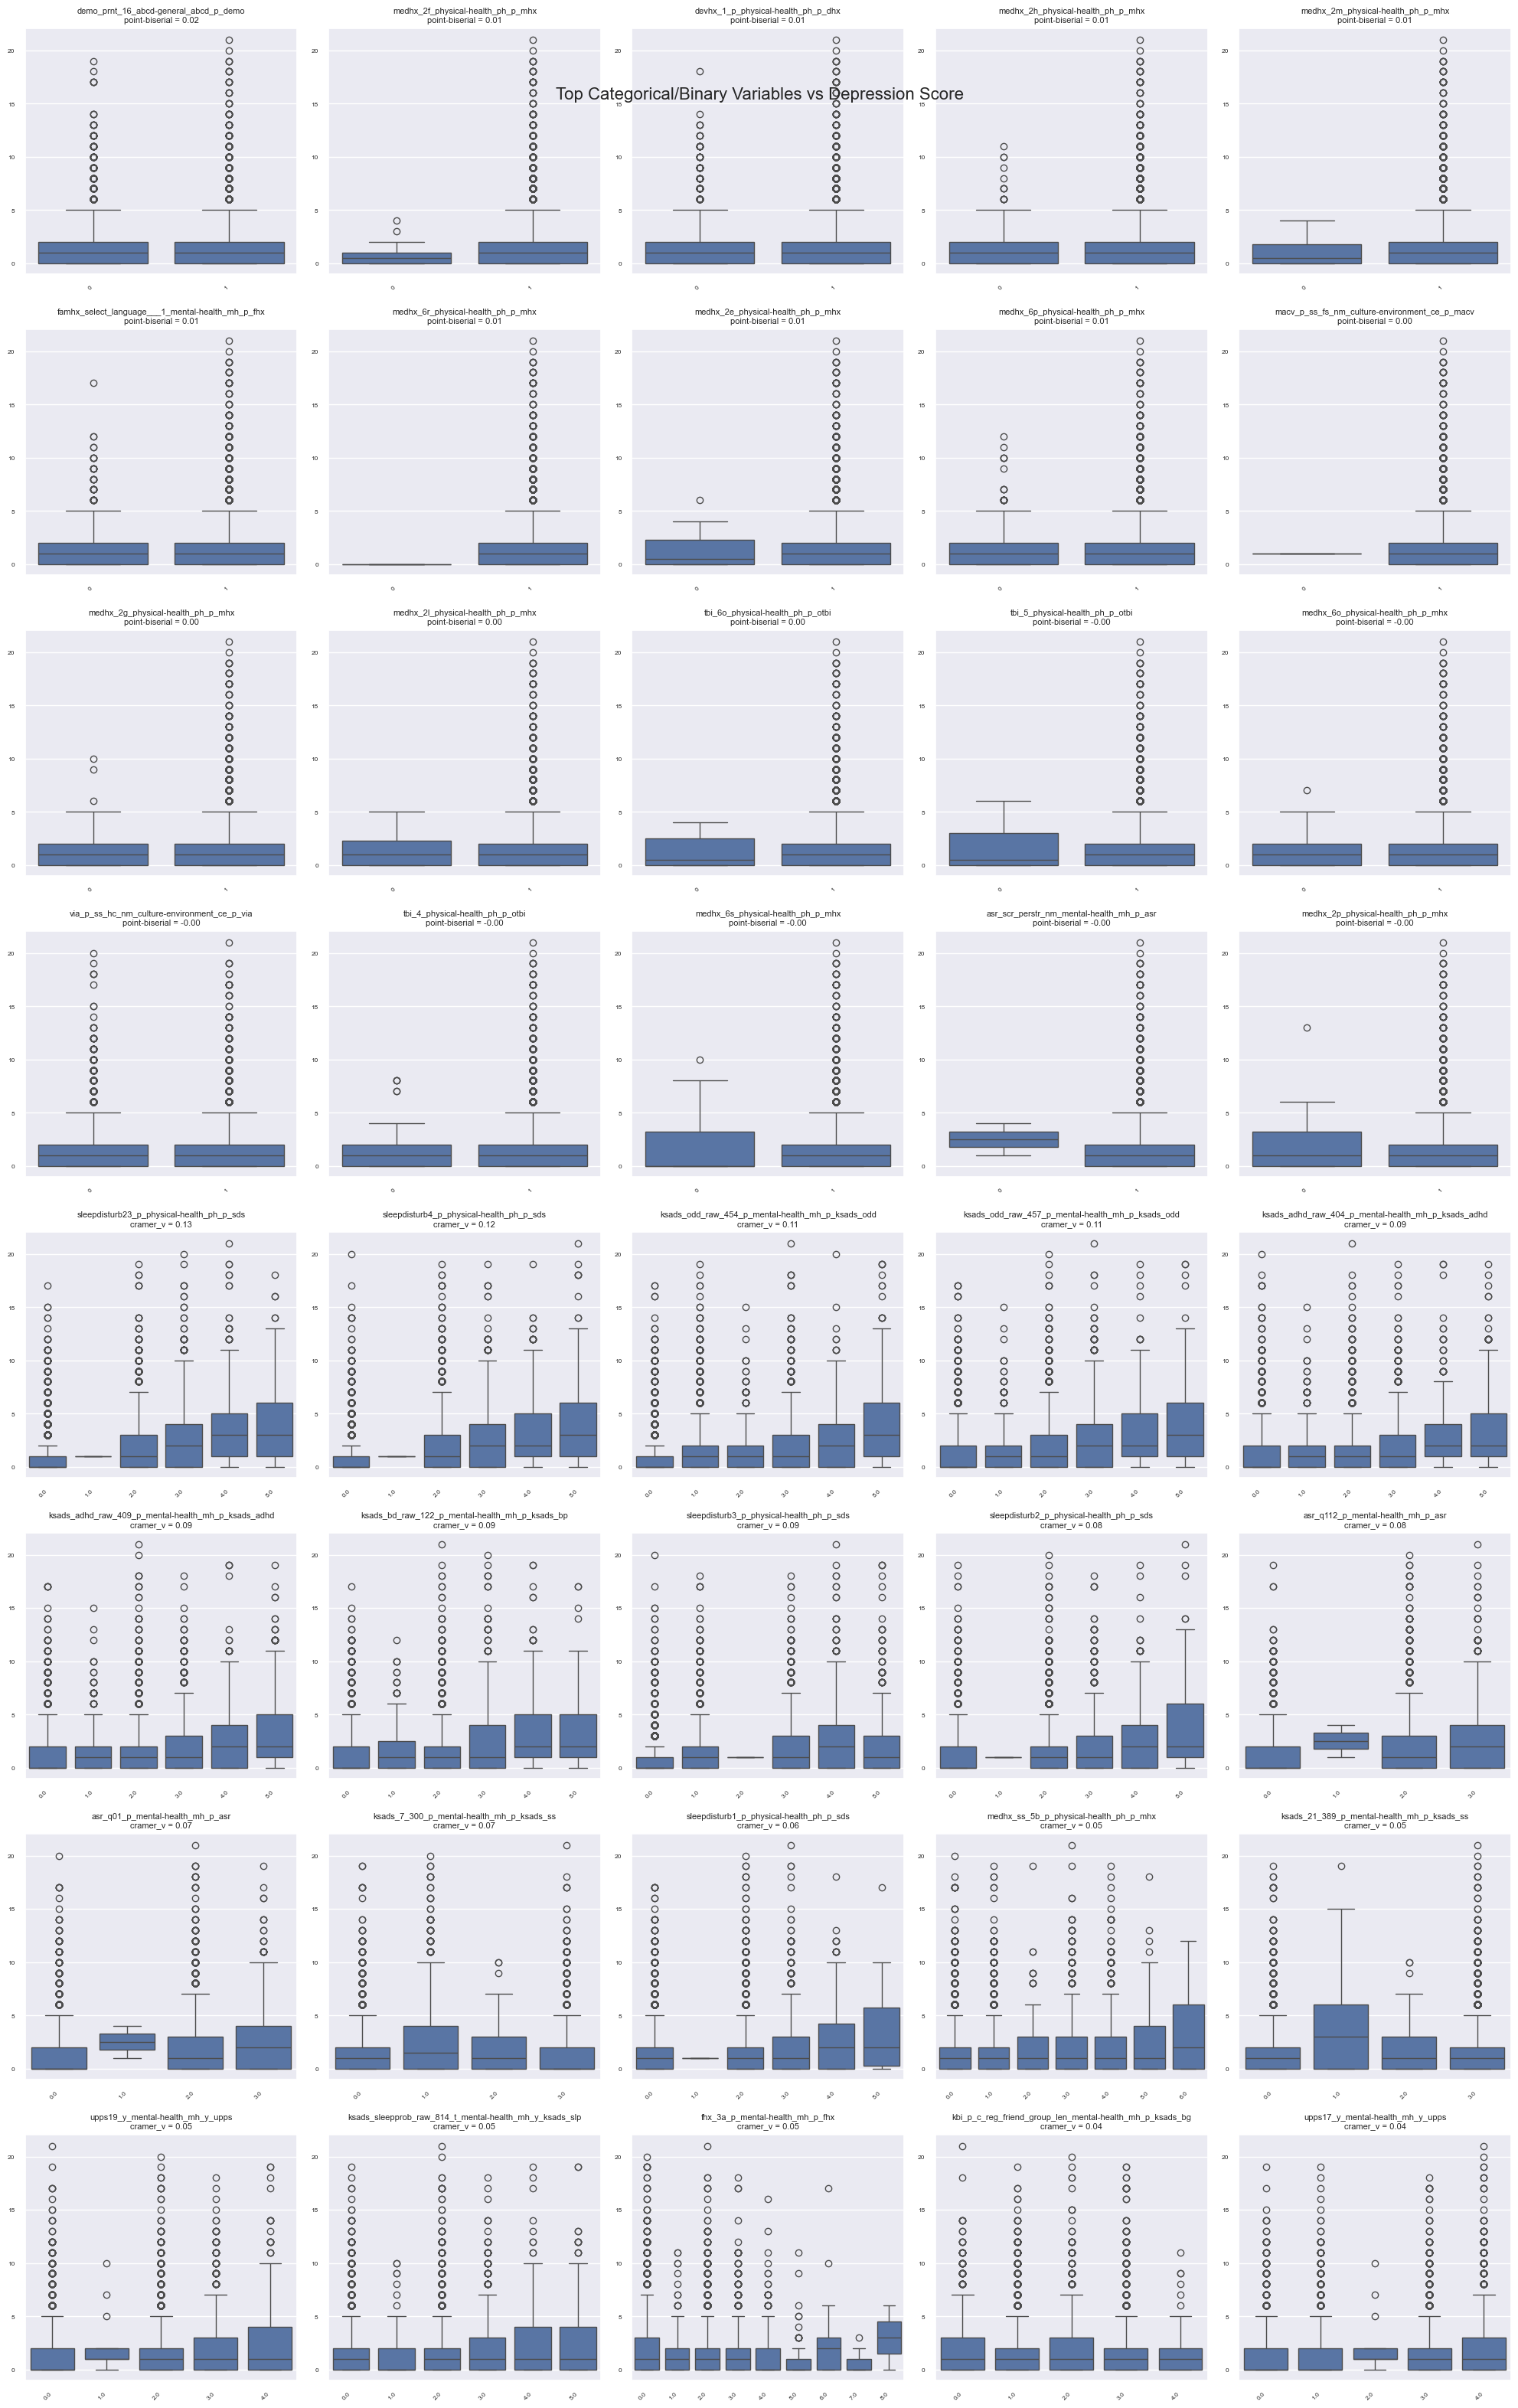

In [18]:
# Plot categorical and binary correlations
binary_categorical = pd.concat([top_binary, top_categorical])
if not binary_categorical.empty:
    plot_categorical_correlations(df, binary_categorical)